<h2>Load dataset from Google Colab</h2>

In [43]:
!pip install kaggle

In [44]:
!git clone https://github.com/sicara/easy-few-shot-learning
%cd easy-few-shot-learning
!pip install .

Cloning into 'easy-few-shot-learning'...
remote: Enumerating objects: 1160, done.
remote: Counting objects: 100% (423/423), done.
remote: Compressing objects: 100% (232/232), done.
remote: Total 1160 (delta 264), reused 242 (delta 189), pack-reused 737
Receiving objects: 100% (1160/1160), 2.32 MiB | 3.23 MiB/s, done.
Resolving deltas: 100% (668/668), done.
/content/easy-few-shot-learning/easy-few-shot-learning
Processing /content/easy-few-shot-learning/easy-few-shot-learning
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for easyfsl: filename=easyfsl-1.5.0-py3-none-any.whl size=72797 sha256=7bc387dc44fd7a7616b7653b63658d4b4f29dac7b04332150b7b8915296b501f
  Stored in directory: /root/.cache/pip/wheels/1d/e1/c6/4ec7c2c4109013181c4f772ff34646b8b9eeb1a08887be35ed
Successfully built easyfsl
  Attempting uninstall: easyfsl
    Found existing installation: easyfsl 1.5.0
    Uninstalling eas

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [47]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [48]:
!chmod 600 ~/.kaggle/kaggle.json

In [49]:
!kaggle datasets download -d arjunashok33/miniimagenet

100% 6.28G/6.28G [04:22<00:00, 25.6MB/s]
100% 6.28G/6.28G [04:22<00:00, 25.6MB/s]


<h2>Unzip Dataset</h2>

In [50]:
zip_path = '/content/easy-few-shot-learning/miniimagenet.zip'
extract_path = '/content/easy-few-shot-learning/data/mini_imagenet'

!unzip -qo {zip_path} -d {extract_path}

<h2>Download Dataset</h2>

In [67]:
from easyfsl.datasets import MiniImageNet
from torchvision import transforms

ImageSize=84

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,)),
    transforms.Resize([ImageSize, ImageSize])
])

train_set = MiniImageNet(root="/content/easy-few-shot-learning/data/mini_imagenet", split="train", training=True,transform=transform)
test_set = MiniImageNet(root="/content/easy-few-shot-learning/data/mini_imagenet", split="test", training=False,transform=transform)

In [68]:
print(len(test_set),len(train_set))

12000 38400


torch.Size([3, 84, 84])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


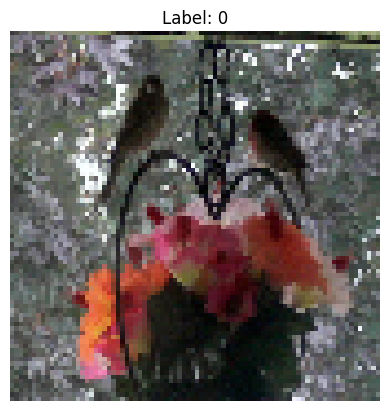

In [69]:
import matplotlib.pyplot as plt

image_index = 220

dataset = train_set

image, label = dataset[image_index]
print(image.shape)
plt.imshow(image.permute(1, 2, 0))
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [70]:
import torch
# Get the tuple from train_set
tuple_data = train_set[10]

# Iterate over each element in the tuple
max_value = float('inf')  # Initialize with a very small value

for element in tuple_data:
    if isinstance(element, torch.Tensor):
        element_max = torch.min(element)
        max_value = min(max_value, element_max)
    else:
        max_value = min(max_value, element)

print(max_value)

0


<h2>Start train and test</h2>

In [71]:
import os
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn, optim

In [72]:
print(len(train_set),len(test_set))

38400 12000


torch.Size([3, 84, 84])


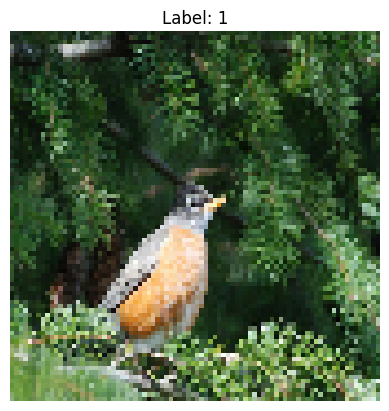

In [73]:
import matplotlib.pyplot as plt

image_index = 750

dataset = train_set

image, label = dataset[image_index]
print(image.shape)
plt.imshow(image.permute(1, 2, 0))
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

<h2>Implement Prototypical Network</h2>

In [74]:
from torchvision.models import resnet18

In [75]:
class PrototypicalNetworks(nn.Module):
  def __init__(self,backbone:nn.Module):
    super(PrototypicalNetworks,self).__init__()
    self.backbone=backbone
  def forward(self,support_images:torch.Tensor,support_labels:torch.Tensor,query_images: torch.Tensor):

    z_support=self.backbone.forward(support_images)
    z_query=self.backbone.forward(query_images)

    n_way=len(torch.unique(support_labels))

    z_proto = torch.cat(
        [
            z_support[torch.nonzero(support_labels == label)].mean(0)
            for label in range(n_way)
        ]
    )

    dists = torch.cdist(z_query, z_proto)
    scores = -dists
    return scores


In [76]:
from torchsummary import summary

convolutional_network=resnet18(pretrained=True)
convolutional_network.fc=nn.Flatten()

# print(convolutional_network)

model=PrototypicalNetworks(convolutional_network).cuda()

# Print the summary of the model
summary(convolutional_network, input_size=(3, 224, 224))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

<h2>Create Support and Query Images</h2>

In [77]:
!pip install easyfsl

In [78]:
from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average
from torch.utils.data import Dataset


In [79]:
print(len(test_set))

12000


In [80]:
print(len(os.listdir('/content/easy-few-shot-learning/data/mini_imagenet')))

103


In [81]:
N_WAY = 5  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 10  # Number of images per class in the query set
N_EVALUATION_TASKS = 100


# # Assign the lambda function to get_labels
test_set.get_labels = lambda: [test_set[i][1] for i in range(len(test_set)) if i < len(test_set)]

test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [82]:
print(len(test_sampler))
print(len(test_loader))

100
100


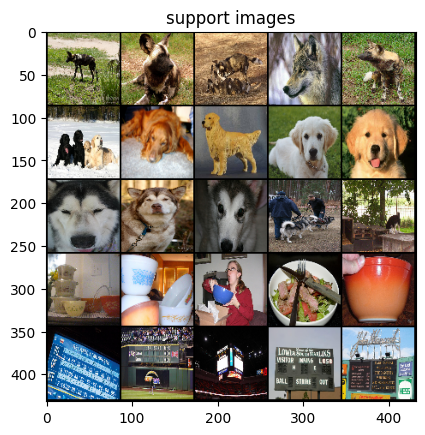

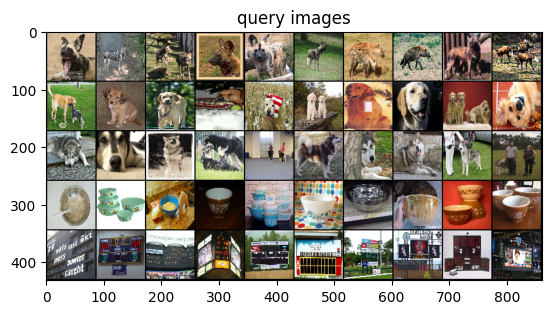

In [83]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

In [84]:
print(example_support_labels)
print(example_query_labels)

tensor([2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4])


In [85]:
model.eval()
example_scores = model(
    example_support_images.cuda(),
    example_support_labels.cuda(),
    example_query_images.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print(example_predicted_labels)
# print("Ground Truth / Predicted")
# for i in range(len(example_query_labels)):
#     print(
#         f"{test_dataset._characters[example_class_ids[example_query_labels[i]]]} / {test_dataset._characters[example_class_ids[example_predicted_labels[i]]]}"
#     )

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 1, 0, 3, 1, 2, 1, 2, 2,
        4, 2, 1, 2, 2, 4, 1, 3, 2, 3, 4, 3, 2, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4], device='cuda:0')


In [86]:
from tqdm import tqdm

In [87]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(test_loader)

100%|██████████| 100/100 [01:05<00:00,  1.53it/s]

Model tested on 100 tasks. Accuracy: 65.36%


<h2>Train the model</h2>

In [88]:
N_TRAINING_EPISODES = 4000
N_VALIDATION_TASKS = 100

train_set.get_labels = lambda: [train_set[i][1] for i in range(len(train_set))]
train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

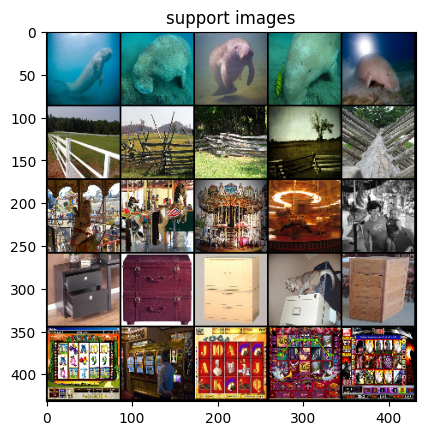

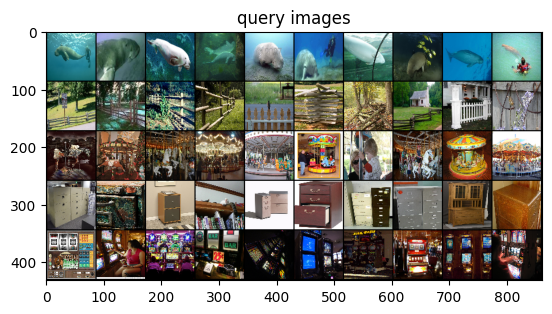

In [89]:
(
    example_support_images_train,
    example_support_labels_train,
    example_query_images_train,
    example_query_labels_train,
    example_class_ids_train,
) = next(iter(train_loader))

plot_images(example_support_images_train, "support images", images_per_row=N_SHOT)
plot_images(example_query_images_train, "query images", images_per_row=N_QUERY)

In [90]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

In [91]:
!pip install torchmetrics

In [92]:
from sklearn.metrics import accuracy_score

def calculate_accuracy(model, images, labels):
    model.eval()
    with torch.no_grad():
        logits = model(images)
        predicted_labels = torch.argmax(logits, dim=1).cuda().numpy()
    model.train()
    accuracy = accuracy_score(labels.cuda().numpy(), predicted_labels)
    return accuracy

In [96]:
# Train the model yourself with this cell
log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - 

In [97]:
# Save the model's state_dict
torch.save(model.state_dict(), '/content/drive/MyDrive/prototypical2.pth')

In [98]:
evaluate(test_loader)

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.

Model tested on 100 tasks. Accuracy: 61.26%


In [ ]:
evaluate(train_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th